In [3]:
import os
import torch
import numpy as np
import cv2
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [4]:
class imgDataset(Dataset):
    def __init__(self, dir, transform=None):
        self.data = []
        self.transform = transform
        for root, dirs, files in os.walk(dir):
            for file in files:
                if not file.startswith('.'):
                    filename = os.path.join(root, file)
                    label = 1 if 'yes' in root else 0
                    self.data.append({'filename': filename, 'label': label})
        random.shuffle(self.data)
        
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            imgs = []
            for x in self.data[idx]:
                name = x['filename']
                img = cv2.imread(name, 0)
                label = x['label']
                if self.transform:
                    img = self.transform(img)
                imgs.append({'image': img, 'label': label, 'name': name})
            return imgs
        name = self.data[idx]['filename']
        img = cv2.imread(name, 0) 
        label = self.data[idx]['label']
        if self.transform:
            img = self.transform(img)
        return {'image': img, 'label': label, 'name': name}
    

    def __len__(self):
        return len(self.data)

In [5]:
class imgCrop(object):
    
    def __call__(self, img):
        gray = cv2.GaussianBlur(img, (5, 5), 0)

        thresh = cv2.threshold(gray, 45, 255, 0)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, 
                                    cv2.CHAIN_APPROX_SIMPLE)[0]
        # contour with largest area
        cnt = max(contours, key=cv2.contourArea)

        # most extreme points of the contour
        leftmost = tuple(cnt[cnt[:,:,0].argmin()][0])
        rightmost = tuple(cnt[cnt[:,:,0].argmax()][0])
        topmost = tuple(cnt[cnt[:,:,1].argmin()][0])
        bottommost = tuple(cnt[cnt[:,:,1].argmax()][0])

        # crop image accordingly
        crop = img[topmost[1]: bottommost[1], leftmost[0]: rightmost[0]]
        # normalize image pixels to values in [0,1]
        crop = cv2.normalize(crop, None, -1.0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        return crop



In [6]:
dir = './archive'
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

mps


In [ ]:
batch_size = 16
transform = T.Compose([imgCrop(), T.ToTensor(), T.Resize((200,200), antialias=True)])
dataset = imgDataset(dir, transform)
k = int(0.6 * len(dataset))
train = dataset[0:k]
test = dataset[k:]
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True)

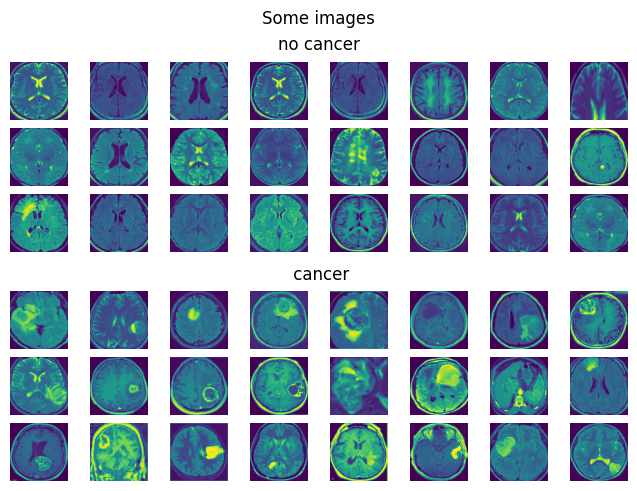

In [7]:
fig = plt.figure(constrained_layout=True)
fig.suptitle('Some images')

# create 2x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(f'{"no" if row == 0 else ""} cancer')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=3, ncols=8)
    i = 0
    for ax in axs.flatten():
        while dataset[i]['label'] != row:
            i += 1
        ax.imshow(dataset[i]['image'].permute(1,2,0))
        ax.axis('off')
        i += 1

In [28]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(64 * 50 * 50, 128)  
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  
        
        self.fc2 = nn.Linear(128, 2) 

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        
        x = x.view(-1, 64 * 50 * 50) 
        
        x = self.dropout(self.relu3(self.fc1(x)))
        x = self.fc2(x)
        
        return x

In [29]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, sample in enumerate(dataloader):
        x, y = sample['image'].to(device), sample['label'].to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 12 == 0:
            loss, current = loss.item(), (batch + 1) * len(sample)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [30]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for sample in dataloader:
            x, y = sample['image'].to(device), sample['label'].to(device)
            pred = model(x)
            #print(pred)
            test_loss += loss_fn(pred, y).item()
            #print(pred)
            #print(pred.max(1).indices)
            correct += (pred.max(1).indices == y).type(torch.int).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [34]:
model = Net().to(device)
lr = 1e-3 #learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()
epoch = 30
for i in range(epoch):
    print(f"---Epoch {i + 1}---")
    train_loop(train_dataloader, model, loss, optimizer)
    test_loop(test_dataloader, model, loss)

---Epoch 1---
loss: 0.703287  [    3/  151]
Test Error: 
 Accuracy: 64.4%, Avg loss: 0.654782 

---Epoch 2---
loss: 0.578678  [    3/  151]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.623374 

---Epoch 3---
loss: 0.606226  [    3/  151]
Test Error: 
 Accuracy: 71.3%, Avg loss: 0.686516 

---Epoch 4---
loss: 0.670931  [    3/  151]
Test Error: 
 Accuracy: 71.3%, Avg loss: 0.642738 

---Epoch 5---
loss: 0.476774  [    3/  151]
Test Error: 
 Accuracy: 71.3%, Avg loss: 0.626123 

---Epoch 6---
loss: 0.345429  [    3/  151]
Test Error: 
 Accuracy: 65.3%, Avg loss: 0.854104 

---Epoch 7---
loss: 0.157599  [    3/  151]
Test Error: 
 Accuracy: 75.2%, Avg loss: 0.639622 

---Epoch 8---
loss: 0.289085  [    3/  151]
Test Error: 
 Accuracy: 74.3%, Avg loss: 0.605674 

---Epoch 9---
loss: 0.304899  [    3/  151]
Test Error: 
 Accuracy: 66.3%, Avg loss: 0.716974 

---Epoch 10---
loss: 0.146076  [    3/  151]
Test Error: 
 Accuracy: 69.3%, Avg loss: 0.904620 

---Epoch 11---
loss: 0.118531  [    3/ 